# Suche nach passenden Zipf / Luhn Parameter 

Um festzustellen, wie viele Wörter duch die Zipf/Luhn Analyse später für jeden Text mindestens bestimmt werden sollen, werden zunächst die folgenden Parameter über alle Texte untersucht:
- Längster Text
- Kürzester Text
- Durchschnittslänge


In [1]:
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import pandas as pd

import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

from IPython.display import display
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [11]:
# Datenbank-Zugangsdaten
username = 'admin'
password = 'admin'
host = 'localhost'
port = '27017'
authSource = 'admin'


# Verbindung zur MongoDB
client = MongoClient(f'mongodb://{username}:{password}@{host}:{port}/?authSource={authSource}')
db = client.web_articles
articles_collection = db.marketwatch_articles

# Artikel aus MongoDB abrufen
#articles_cursor_ = articles_collection.find({}, {'preprocessed_text': 1, '_id': 1})
articles_cursor_ = articles_collection.find({}, {'text': 1, '_id': 1})

## Wie lang sind die Texte in der DB?

Kürzester Text:  0
Längster Text:  12281
Durchschnittliche Anzahl der Wörter:  658.7416829745597


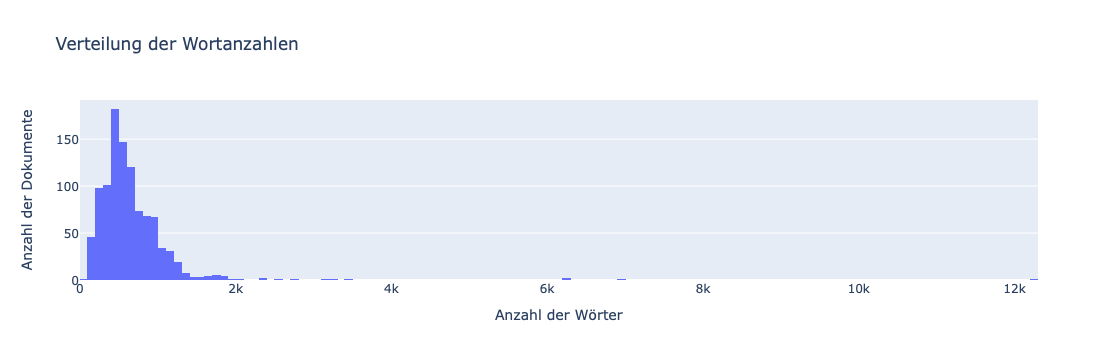

In [13]:
# Artikel aus MongoDB abrufen
articles_cursor = articles_cursor_.clone()

# Listen und Variablen für Daten und Längeninformationen
texts = []
word_counts = []
ids = []
min_length = 0  # Unendlich hoch initialisieren
max_length = 0
total_length = 0
total_documents = 0
min_text = ""
max_text = ""

# Daten aus Cursor extrahieren und Längen analysieren
for article in articles_cursor:
    text = article.get('preprocessed_text', "")
    words = text.split()
    word_count = len(words)
    
    # Textdaten für den Graphen sammeln
    texts.append(text)
    word_counts.append(word_count)
    ids.append(str(article['_id']))  # Konvertiere ObjectId zu string für die Anzeige

    # Längeninformationen aktualisieren
    total_length += word_count
    total_documents += 1

    if word_count < min_length:
        min_length = word_count
        #min_text = text

    if word_count > max_length:
        max_length = word_count
        #max_text = text

# Durchschnittliche Wortanzahl berechnen
average_length = total_length / total_documents if total_documents > 0 else 0

# Ergebnisse ausgeben
print("Kürzester Text: ", min_length)
print("Längster Text: ", max_length)
print("Durchschnittliche Anzahl der Wörter: ", average_length)

# Daten in einen DataFrame umwandeln
df = pd.DataFrame({
    'Text': texts,
    'Word Count': word_counts,
    'ID': ids
})

# DataFrame nach 'Word Count' absteigend sortieren
df = df.sort_values(by='Word Count', ascending=False)
df

# Histogramm erstellen mit Plotly Express
fig = px.histogram(df, x='Word Count', nbins=200, title="Verteilung der Wortanzahlen")
fig.update_layout(xaxis_title='Anzahl der Wörter', yaxis_title='Anzahl der Dokumente')
fig.show()

## Zipf Luhn & TDF-IDF

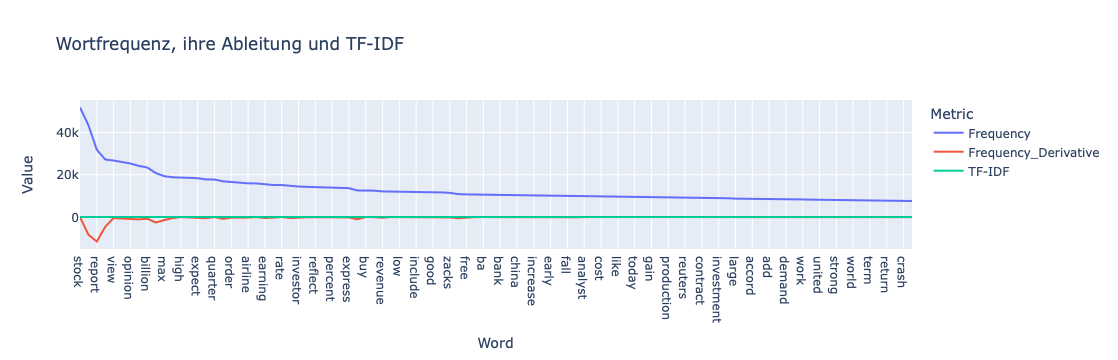

In [156]:
# Artikel aus MongoDB abrufen
articles_cursor = articles_cursor_.clone()

# Konfigurationseinstellungen
config = {
    'stop_words': 'english',  # Stopwörter für Englisch
    'n_keywords': 100,  # Anzahl der Schlüsselwörter, die maximal angezeigt werden sollen
    'min_df': 5,   # Minimale Dokumentfrequenz für Wörter
    'max_df': 0.7, # Maximale Dokumentfrequenz für Wörter (als Anteil)
}

all_texts = []
article_ids = []
word_counts = []

# Texte und IDs sammeln und Wortzählung durchführen (ersetzen Sie dies durch Ihren tatsächlichen Code)
for article in articles_cursor:
    text = article['preprocessed_text']
    if text.strip():  # Überprüfen, ob der Text nicht leer ist
        all_texts.append(text)
        article_ids.append(article['_id'])
        word_counts.append(len(set(text.split())))  # Zählen der einzigartigen Wörter

# CountVectorizer initialisieren
vectorizer = CountVectorizer(stop_words=config['stop_words'], min_df=config['min_df'], max_df=config['max_df'])

# Texte transformieren
count_matrix = vectorizer.fit_transform(all_texts)

# Summe der Häufigkeiten für jedes Wort über alle Texte
word_frequencies = count_matrix.sum(axis=0).A1

# Feature-Namen (Wörter) aus dem Vectorizer extrahieren
feature_names = vectorizer.get_feature_names_out()

# DataFrame erstellen
frequency_df = pd.DataFrame(list(zip(feature_names, word_frequencies)), columns=['Word', 'Frequency'])

# DataFrame nach Häufigkeit sortieren
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Ränge hinzufügen
frequency_df['Rank'] = frequency_df['Frequency'].rank(ascending=False, method='first').astype(int)

# Die obere Grenze von Wörtern setzen gemäß der Konfiguration
frequency_df = frequency_df.head(config['n_keywords'])

# Ableitung der Frequenz berechnen
frequency_df['Frequency_Derivative'] = frequency_df['Frequency'].diff().fillna(0)

# Berechnen der TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=config['stop_words'], min_df=config['min_df'], max_df=config['max_df'])
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)
tfidf_values = tfidf_matrix.sum(axis=0).A1

# Hinzufügen der TF-IDF-Werte zum DataFrame
frequency_df['TF-IDF'] = tfidf_values[frequency_df.index]

# DataFrame für den Plot vorbereiten (Melting für Plotly Express)
melted_df = frequency_df.melt(id_vars=['Word', 'Rank'], value_vars=['Frequency', 'Frequency_Derivative', 'TF-IDF'],
                              var_name='Metric', value_name='Value')

# Plot erstellen
fig = px.line(melted_df, x='Word', y='Value', color='Metric', hover_data=['Value', 'Word', 'Rank'],
              title='Wortfrequenz, ihre Ableitung und TF-IDF')

# Anpassen der Achsen für eine bessere Lesbarkeit
fig.update_xaxes(type='category')

# Diagramm anzeigen
fig.show()
#frequency_df[['Word', 'Frequency', 'TF-IDF']].head(40)


### Normalisiert

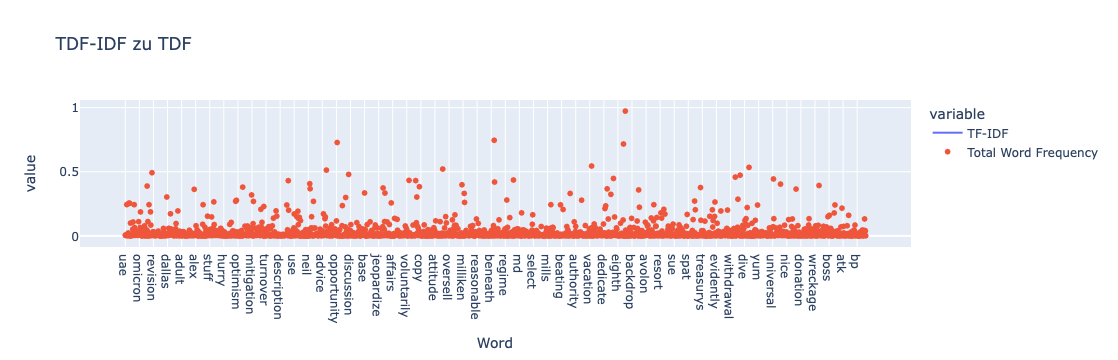

In [162]:
# Artikel aus MongoDB abrufen
articles_cursor = articles_cursor_.clone()

# Konfigurationseinstellungen
config = {
    'sort_by_tf_idf' : True,
    'stop_words': 'english',  # Stopwörter für Englisch
    'n_keywords': 2000,  # Anzahl der Schlüsselwörter, die maximal angezeigt werden sollen
    'min_df': 50,   # Minimale Dokumentfrequenz für Wörter
    'max_df': 0.4, # Maximale Dokumentfrequenz für Wörter (als Anteil)
}

all_texts = []

# Texte sammeln (ersetzen Sie dies durch Ihren tatsächlichen Code)
for article in articles_cursor:
    text = article['preprocessed_text']
    if text.strip():  # Überprüfen, ob der Text nicht leer ist
        all_texts.append(text)

# CountVectorizer initialisieren
vectorizer = CountVectorizer(stop_words=config['stop_words'], min_df=config['min_df'], max_df=config['max_df'])

# Texte transformieren
count_matrix = vectorizer.fit_transform(all_texts)

# Summe der Häufigkeiten für jedes Wort über alle Texte
word_frequencies = count_matrix.sum(axis=0).A1

# Feature-Namen (Wörter) aus dem Vectorizer extrahieren und DataFrame erstellen
feature_names = vectorizer.get_feature_names_out()
frequency_df = pd.DataFrame({'Word': feature_names, 'Frequency': word_frequencies})

# DataFrame nach Häufigkeit sortieren und Ränge hinzufügen
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
frequency_df['Rank'] = frequency_df['Frequency'].rank(ascending=False, method='first').astype(int)

# Ableitung der Frequenz berechnen
frequency_df['Frequency_Derivative'] = frequency_df['Frequency'].diff().fillna(0)

# Berechnen der TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=config['stop_words'], min_df=config['min_df'], max_df=config['max_df'])
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)
tfidf_values = tfidf_matrix.sum(axis=0).A1

# Hinzufügen der TF-IDF-Werte zum DataFrame
frequency_df['TF-IDF'] = tfidf_values[frequency_df.index]

# Normalisieren der Werte
scaler = MinMaxScaler()
frequency_df[['Frequency', 'TF-IDF', 'Frequency_Derivative']] = scaler.fit_transform(frequency_df[['Frequency', 'TF-IDF', 'Frequency_Derivative']])

# Umkehren der Skala für die Ableitung
frequency_df['Frequency_Derivative'] = 1 - frequency_df['Frequency_Derivative']

# Überprüfen, ob nach TF-IDF-Werten sortiert werden soll
if config['sort_by_tf_idf']:
    frequency_df = frequency_df.sort_values(by='TF-IDF', ascending=False).reset_index(drop=True)

# Die oberen n Keywords auswählen
frequency_df = frequency_df.head(config['n_keywords'])

if config['sort_by_tf_idf'] == False:
    # Plot erstellen
    fig = px.line(frequency_df, x='Word', y=['Frequency', 'Frequency_Derivative'], title='Wortfrequenz und ihre Ableitung')
    fig.add_scatter(x=frequency_df['Word'], y=frequency_df['TF-IDF'], mode='markers', name='TF-IDF')
else:
    # Plot erstellen
    fig = px.line(frequency_df, x='Word', y=['TF-IDF'], title='TDF-IDF zu TDF')
    fig.add_scatter(x=frequency_df['Word'], y=frequency_df['Frequency'], mode='markers', name='Total Word Frequency')

# Anpassen der Achsen für eine bessere Lesbarkeit
fig.update_xaxes(type='category')

# Diagramm anzeigen
fig.show()


# Ausgabe der ersten 40 Zeilen des DataFrame
#display(frequency_df[['Word', 'Frequency', 'TF-IDF']][0:config['n_keywords']])

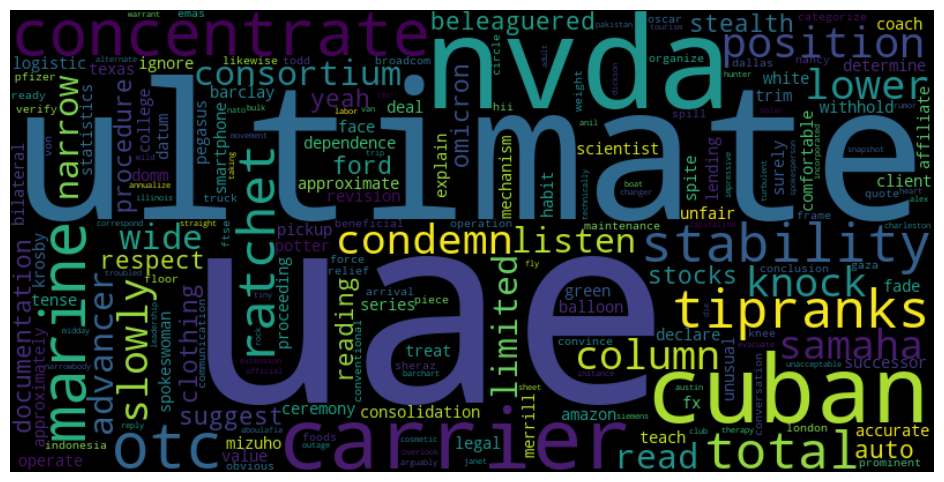

In [159]:
if config['sort_by_tf_idf'] == False:
    # WordCloud erstellen und generieren direkt aus dem DataFrame
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(dict(zip(frequency_df['Word'], frequency_df['Frequency'])))
else:
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(dict(zip(frequency_df['Word'], frequency_df['TF-IDF'])))
# WordCloud anzeigen
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [160]:
# Benutzer zur Eingabe auffordern
w = input("Wort:")

# Überprüfen, ob das Wort in der Spalte 'Word' vorhanden ist
if frequency_df['Word'].str.contains(w, case=False, na=False).any():
    display(frequency_df[frequency_df['Word'].str.contains(w, case=False, na=False)])
else:
    print(w, "nicht gefunden!")


Wort: max


max nicht gefunden!
